# Mantis Rock Physics Library
### Author: G. Papageorgiou
In this notebook we showcase the palette of rock physics models in the mantis codebase.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import mantis_core.rock_physics as manRP
import mantis_core.rock_physics.fluid as manFL
from mantis_core.rock_physics.fluid_presets import presets as manPResets
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("plotting.mantis_plotting")
import numpy as np

We first define a fluid

In [16]:
water = manFL.Fluid.from_presets(name="Water", temperature=30, pressure=25)
co2 = manFL.Fluid.from_presets(name="CarbonDioxide", temperature=30, pressure=25)
water_co2_mix = manFL.FluidMix(fluid1=water, fluid2=co2)

Using in-situ values, we have a pallette of models that can be evaluated and calibrated to these in situ values. The calibration is such that the models are consistent with the in-situ values.

In [17]:
in_situ = {"Vp": 3.8, "Vs": 1.8, "Rho": 2.5}
water_co2_mix.saturation = 1
parameters = {
    "Phi": 0.2,
    "Km": 37.5,
    "fluid": water_co2_mix,
    "permeability": 1e-12,
    "patch_size": 0.0005,
    "bubble_radius": 0.0005,
    "Q_sls":10,
    "Log_omega_ref":0,
    "crack_density": 0.1,
    "aspect_ratio": 0.001,
    "eps": 0.1,
    # "tau": np.log10(1 / 2 / np.pi / 35),
    "tau":10
}

pars = {**in_situ, **parameters}

In [18]:

models = {
    str(model.__name__).split(".")[-1]: {
        "name": model.Model.name,
        "type": model.Model.model_type.split(","),
    }
    for model in manRP.model_factory.ModelsBuild.models
}
calibrated = {model: manRP.models(identifier=model, **pars) for model in models}

Plotting the models as a function of saturation we can see that they have been calibrated to the in-situ values.

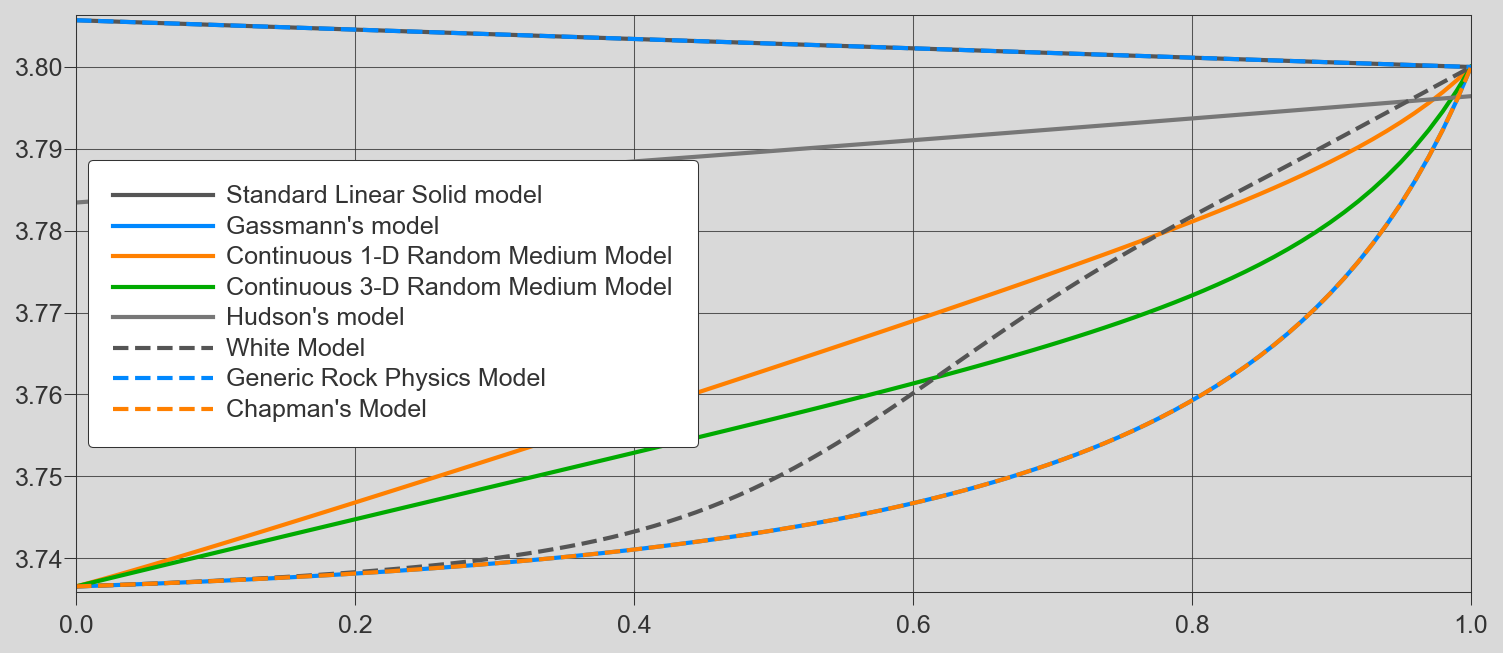

In [19]:
s = np.linspace(0, 1, 100)
water_co2_mix.saturation = 1
density = manRP.density.Density.from_insitu(Rho=in_situ["Rho"], fluid=water_co2_mix, Rho_d=2.65)

fig, ax = plt.subplots()
data = np.empty((len(calibrated), len(s)))
for j, sat in enumerate(s):
    water_co2_mix.saturation = sat
    for i, model in enumerate(calibrated.items()):
        m, v = model
        data[i, j] = np.sqrt(np.real(v.Cij()[0,0] / density()))
for i, d in enumerate(data):
    if i>4:
        dash = '--'
    else:
        dash = '-'
    ax.plot(s, d, label=calibrated[list(calibrated.keys())[i]].name, lw=2, linestyle=dash)
ax.legend()
plt.show()
plt.close()

Every model has a `Cij` method which is a function of log frequency. In the case of frequency independent models, this is a constant function. If called with no arguments, it is evaluated at the in-situ frequency which is by default set to 1Hz.

In [26]:
calibrated["hudson"].Cij()

array([[36.0322865 , 19.8322865 , 19.77716295,  0.        ,  0.        ,
         0.        ],
       [19.8322865 , 36.0322865 , 19.77716295,  0.        ,  0.        ,
         0.        ],
       [19.77716295, 19.77716295, 35.87716494,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  6.4067101 ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  6.4067101 ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         8.1       ]])

In [29]:
calibrated["sls"].Cij(), calibrated["sls"].Cij(omega=-1)

(array([[36.1+3.61j, 19.9+1.99j, 19.9+1.99j,  0. +0.j  ,  0. +0.j  ,
          0. +0.j  ],
        [19.9+1.99j, 36.1+3.61j, 19.9+1.99j,  0. +0.j  ,  0. +0.j  ,
          0. +0.j  ],
        [19.9+1.99j, 19.9+1.99j, 36.1+3.61j,  0. +0.j  ,  0. +0.j  ,
          0. +0.j  ],
        [ 0. +0.j  ,  0. +0.j  ,  0. +0.j  ,  8.1+0.81j,  0. +0.j  ,
          0. +0.j  ],
        [ 0. +0.j  ,  0. +0.j  ,  0. +0.j  ,  0. +0.j  ,  8.1+0.81j,
          0. +0.j  ],
        [ 0. +0.j  ,  0. +0.j  ,  0. +0.j  ,  0. +0.j  ,  0. +0.j  ,
          8.1+0.81j]]),
 array([[32.56148515+0.71485149j, 17.94940594+0.39405941j,
         17.94940594+0.39405941j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [17.94940594+0.39405941j, 32.56148515+0.71485149j,
         17.94940594+0.39405941j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [17.94940594+0.39405941j, 17.94940594+0.39405941j,
         32.56148515+0.71485149j,  0.

One can check that at the in-situ frequency, the models are consistent with the in-situ values and each other

In [8]:
[val.Cij(omega=0)[0,0] for model, val in calibrated.items()]

[(36.1+3.6100000000000017j),
 36.1,
 36.1,
 36.1,
 36.0322864998137,
 36.1,
 36.1,
 (36.1+0j)]

A reference for each model is provided as part of their docsting

In [24]:
for model in manRP.model_factory.ModelsBuild.models:
    if " frequency-dependent" in model.Model.model_type.split(","):
        print("{0:-^55}".format(f"{model.Model.name}", fill="center", align="center"))
        print(f"{model.Model.reference}\n\n")


--------------Standard Linear Solid model--------------

    Ursin, Björn, and Tommy Toverud. 
    'Comparison of seismic dispersion and attenuation models.' 
    Studia geophysica et geodaetica 46 (2002): 293-320.
    


----------Continuous 1-D Random Medium Model-----------

    Caspari, Eva, T. M. Müller, and Boris Gurevich.
    `Time-lapse sonic logs reveal patchy CO2 saturation in‐situ.`
    Geophysical Research Letters 38.13 (2011).
    


----------Continuous 3-D Random Medium Model-----------

    Caspari, Eva, T. M. Müller, and Boris Gurevich.
    `Time‐lapse sonic logs reveal patchy CO2 saturation in‐situ.`
    Geophysical Research Letters 38.13 (2011).
    


----------------------White Model----------------------

    - original reference:
    
        White, J. E. 
        "Computed seismic speeds and attenuation in rocks 
        with partial gas saturation." 
        Geophysics 40.2 (1975): 224-232.

    - Dutta-Seriff corrections:

        Dutta, N. C., and A. J. Serif